# BEE 4750 Homework 5: Solid Waste Disposal

**Name**: Elliot Walsh

**ID**: ejw224, 5101573

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [26]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using LinearAlgebra

  Activating project at `~/Desktop/fall 2023/cee 4750/hw 5/hw05-ejw224`


## Background

Three cities are developing a coordinated municipal solid waste (MSW)
disposal plan. Three disposal alternatives are being considered: a
landfill (LF), a materials recycling facility (MRF), and a
waste-to-energy facility (WTE). The capacities of these facilities and
the fees for operation and disposal are provided in the table below.

|    **Disposal Facility**     | **Capacity** (Mg/d) | **Fixed cost** (\$/d) | **Tipping Fee ** (\$/Mg) | **Recycling Cost** (\$/Mg) |
|:-------------:|:-------------:|:-------------:|:----------:|:--------------:|
|           Landfill           |         200         |         2000          |            50            |                            |
| Materials Recycling Facility |         350         |         1500          |            7             |    40 (per Mg recycled)    |
|   Waste-to-Energy Facility   |         210         |         2500          |            60            |                            |

Transportation costs are \$1.5/Mg-km, and the relative distances between
the cities and facilities are provided in the table below.

| **City/Facility** | **Landfill (km)** | **MRF (km)** | **WTE (km)** |
|:-----------------:|:-----------------:|:------------:|:------------:|
|         1         |         5         |      30      |      15      |
|         2         |        15         |      25      |      10      |
|         3         |        13         |      45      |      20      |
|        LF         |        \-         |      32      |      18      |
|        MRF        |        32         |      \-      |      15      |
|        WTE        |        18         |      15      |      \-      |

The fixed costs associated with the disposal options are incurred only
if the particular disposal option is implemented. The three cities
produce 100, 90, and 120 Mg/day of solid waste, respectively, with the
composition provided in the table below.

|   **Component**   | **% of total mass** | **Combustion ash** (%) | **MRF Recycling rate** (%) |
|:---------------------:|:--------------:|:---------------:|:---------------:|
|    Food Wastes    |         15          |           8            |             0              |
| Paper & Cardboard |         40          |           7            |             55             |
|     Plastics      |          5          |           5            |             15             |
|     Textiles      |          3          |           10           |             10             |
|  Rubber, Leather  |          2          |           15           |             0              |
|       Wood        |          5          |           2            |             30             |
|    Yard Wastes    |         18          |           2            |             40             |
|       Glass       |          4          |          100           |             60             |
|      Ferrous      |          2          |          100           |             75             |
|     Aluminum      |          2          |          100           |             80             |
|    Other Metal    |          1          |          100           |             50             |
|   Miscellaneous   |          3          |           70           |             0              |

The information in the above table will help you determine the overall
recycling and ash fractions. Note that the recycling residuals, which
may be sent to either landfill or the WTE, have different ash content
than the ash content of the original MSW. You will need to determine
these fractions to construct your mass balance constraints.

**Reminder**: Use `round(x; digits=n)` to report values to the
appropriate precision!

## Problems (Total: 40 Points)

### Problem 1 (22 points)

In this problem, you will develop an optimal disposal plan for the two
cities.

#### Problem 1.1 (3 points)

Based on the information above, calculate the overall recycling and ash
fractions for the waste produced by each city.

In [28]:
waste_type_masses = [.15 .4 .05 .03 .02 .05 .18 .04 .02 .02 .01 .03];
waste_type_ashes = [.08 .07 .05 .1 .15 .02 .02 1 1 1 1 .7];
waste_type_recycling = [0 .55 .15 .1 0 .3 .4 .6 .75 .8 .5 0];

overall_ash_fraction = dot(waste_type_masses, waste_type_ashes);
overall_recycling_fraction = dot(waste_type_masses, waste_type_recycling);
print("overall recycling fraction: ", round(100*overall_recycling_fraction, digits=1), 
"%, overall ash fraction: ", round(100*overall_ash_fraction, digits=1), "%")

overall recycling fraction: 37.8%, overall ash fraction: 16.4%

#### Problem 1.2 (2 points)

What are the decision variables for your optimization problem? Provide
notation and variable meaning.

$W_{i,j}=$ mass of waste transported from city $i$ to disposal site $j$ (Mg)

$R_{k,j}=$ mass of waste transported from disposal site $k$ to disposal site $j$ (Mg)

$Y_j=$ operational status (on/off) of disposal site $j$ (0/1)

#### Problem 1.3 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s).

$q=$ overall ash fraction = $16.4\%$

$r=$ overall recycling fraction = $37.8\%$

$a=$ cost to transport waste (\$/Mg-km) $=\$1.50/(Mg-km)$

$l_{i,j}=$ distance from source $i$ to disposal site $j$ (km)

$c_j=$ fixed cost to operate disposal $j$ ($/day)

$b_j=$ variable cost to operate disposal $j$ ($/Mg)

$K_j=$ capacity of disposal $j$ (Mg/day)

$S_i=$ waste generated at source $i$ (Mg/day)

Minimize cost $C=$ transportation costs + fixed costs + variable costs 

$$\min_{W_{i,j}, R_{i,j}, Y_j} C=\sum_i \sum_j a l_{i,j} W_{i,j} + \sum_j \sum_k a l_{j,k} R_{j,k}    + \sum_j (c_j Y_j + \sum_i b_j W_{i,j}) $$

#### Problem 1.4 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

$$Y_j = \begin{cases}
0 & \text{if} & \sum_{i \in \mathcal{I}}W_{i,j} + \sum_{k \in \mathcal{K}} R_{k,j} = 0\\
1 & \text{if} & \sum_{i \in \mathcal{I}}W_{i,j} + \sum_{k \in \mathcal{K}} R_{k,j} > 0\\
\end{cases} \\

\sum_i W_{i,j} + \sum_k W_{k,j} \leq K_j \\

\sum_j W_{i,j} = S_i \\

W_{i,j}, R_{i,j} \geq 0\\

R_{j,j}=0 \\

\sum_j R_{2,j} = r(\sum_i W_{i,2} + \sum_k R_{k,2}) \\

\sum_j R_{3,j} = q(\sum_i W_{i,3} + \sum_k R_{k,3}) \\

$$

#### Problem 1.5 (3 points)

Implement your optimization problem in `JuMP`.

In [30]:
q=.164; #ash fraction
r=1-.378; #recycling fraction
a=1.5; #transportation cost

#distances between cities+facilities, facilities+facilities
l=[5 3 15;
15 25 10;
12 45 20;
0 32 18;
32 0 15;
18 15 0];

c=[2000 1500 2500]; #fixed costs of each facility
b=[50 7+40*(1-r) 60]; #variable costs of each facility
k=[200 350 210]; #capacity of each facility
s=[100 90 120]; #waste generated by each city

#vectors representing cities and disposal facilities
cities=1:3;
facilities=1:3;
all_sites=1:6;

model_15 = Model(HiGHS.Optimizer);
@variable(model_15, W[i in cities, j in facilities] >=0);
@variable(model_15, R[m in facilities, j in facilities] >=0);
@variable(model_15, Y[j in facilities] >=0, Bin);

#big-M constraint, M=1000000000
for j in facilities
    @constraint(model_15, 1000000000*Y[j]>= sum(W[i,j] for i in cities) + sum(R[m, j] for m in facilities));
end
#capacity constraint
for j in facilities
    @constraint(model_15, sum(W[i,j] for i in cities)+sum(R[m,j] for m in facilities) <= k[j]);
end

#total waste constraint
for i in cities
    @constraint(model_15, sum(W[i,j] for j in facilities) == s[i]);
end

#waste can't go to the same facility twice
for j in facilities
    @constraint(model_15, R[j,j] == 0)
end

#waste can't go to from landfill to recycling or WTE
@constraint(model_15, R[1,2]==0);
@constraint(model_15, R[1,3]==0);

#ash can't be recycled
@constraint(model_15, R[3,2]==0);

#recycling must go somewhere constraint
@constraint(model_15, R[2,1]+R[2,3] == r*sum(W[i,2] for i in cities)+sum(R[j,2] for j in facilities));

#ashes must go to the landfill constraint
@constraint(model_15, R[3,1] == q*sum(W[i,3] for i in cities)+sum(R[j,3] for j in facilities));

#cost objective
@objective(model_15, Min, a*sum(l[i,j]*W[i,j] for i in cities for j in facilities)
+a*sum(l[j+3,m]*R[j,m] for j in facilities for m in facilities)
+sum(c[j]*Y[j] + sum(b[j]*W[i,j] for i in cities) for j in facilities));

print(optimize!(model_15))
W_15=value.(W);
R_15=value.(R);
Y_15=value.(Y);
objective_15=objective_value(model_15);


Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
10 rows, 15 cols, 43 nonzeros
9 rows, 12 cols, 38 nonzeros
7 rows, 11 cols, 26 nonzeros

Solving MIP model with:
   7 rows
   11 cols (2 binary, 0 integer, 0 implied int., 9 continuous)
   26 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   2000            inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   2000            26930.927273      92.57%        0      0      0         0     0.0s
         0       0         0   0.00%   24111.279179    26930.927273      10.47%        0      0      0         4     0.0s
 T       0       0         0   0.00%   26228.582343    26657.368421       1.61%       12      3     

#### Problem 1.6 (2 points)

Find the optimal solution. Report the optimal objective value.

In [31]:
println("The objective solution is as follows: cost = \$", round(objective_15, digits=2), ", Y_LF = ", Y_15[1], ", Y_MRF = ", Y_15[2]
, ", Y_MTE = ", Y_15[3], "; \n \n W:\n", W_15, "\n \n R: \n", R_15);



The objective solution is as follows: cost = $26657.37, Y_LF = 1.0, Y_MRF = -0.0, Y_MTE = 1.0; 
 
 W:
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{Float64}:
 100.0               -0.0   0.0
  -0.0                0.0  90.0
  78.42105263157896   0.0  41.57894736842104
 
 R: 
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:3
And data, a 3×3 Matrix{Float64}:
  0.0               0.0  0.0
  0.0               0.0  0.0
 21.57894736842105  0.0  0.0


#### Problem 1.7 (5 points)

Draw a diagram showing the flows of waste between the cities and the
facilities. Which facilities (if any) will not be used? Does this
solution make sense?

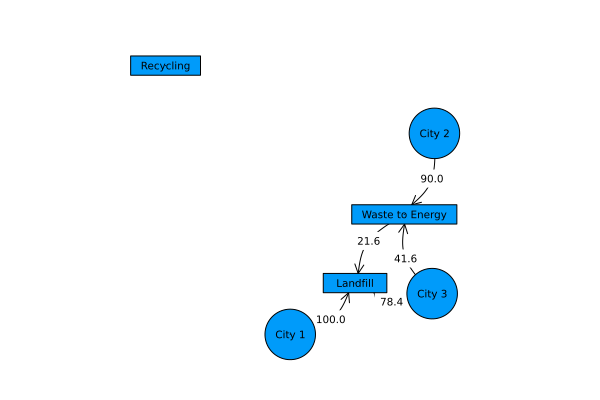

In [33]:
#A = [0 1 1 1 0 0;
    #0 0 0 1 0 0;
    #0 0 0 1 0 0;
    #0 0 0 0 0 0
    #0 0 0 0 0 0
    #0 0 0 0 0 0]

#=
A=  [0 0 0 5 3 15;
    0 0 0 15 25 10;
    0 0 0 12 45 20;
    0 0 0 0 32 18;
    0 0 0 32 0 15;
    0 0 0 18 15 0];

    =#
A=  [0 0 0 1 0 0;
    0 0 0 0 0 1;
    0 0 0 1 0 1;
    0 0 0 0 0 0;
    0 0 0 0 0 0;
    0 0 0 1 0 0];
location_names = ["City 1", "City 2", "City 3", "Landfill", "Recycling", "Waste to Energy"];
shapes=[:circle, :circle, :circle, :rect, :rect, :rect]

edge_labels = Dict((1, 4) => round(W_15[1,1]; digits=1), (1,5) => round(W_15[1,2]; digits=1), (1, 6) => round(W_15[1,3]; digits=1)
,(2, 4) => round(W_15[2,1]; digits=1),(2, 5) => round(W_15[2,2]; digits=1), (2, 6) => round(W_15[2,3]; digits=1)
, (3, 4) => round(W_15[3,1]; digits=1), (3, 5) => round(W_15[3,2]; digits=1), (3, 6) => round(W_15[3,3]; digits=1)
, (5,4) => round(R_15[2,1]; digits=1), (5,6) => round(R_15[2,3]; digits=1), (6,4) => round(R_15[3,1]; digits=1))

#xpos=[-3 -1 -3 1 2 1];
#ypos=[2 0 -2 1 0 -1];

#graphplot(A, names=location_names, markershapes=shapes, edgelabel=edge_labels, x=xpos, y=ypos);
graphplot(A, names=location_names, markershapes=shapes, edgelabel=edge_labels, markersize=0.1)


The percentages of each city's waste that's sent to each facility seem to roughly correspond to the distance between the city and each facility. The recycling facility isn't used (as a result of its further distance from the cities), but mass conservation is preserved and the ashes from WTE facility are sent to the landfill.

### Problem 2 (18 points)

It is projected that in the near future the state will introduce a
carbon tax that will increase the cost for transportation and for
disposal by incineration. It is estimated that the additional costs will
be:

-   tipping fee for the WTE facility will increase to\$75/Mg; and
-   transportation costs will increase to \$2/Mg-km.

In this context, the cities are considering adding another landfill and
want to know if this would be cost-effective compared to using the
current facilities with the carbon tax. This landfill would have a
maximum capacity of 100 Mg/day and would be located with the following
distances from the existing sites (excluding LF1):

| **City/Facility** | **Distance to LF2 (km)** |
|:-----------------:|:------------------------:|
|         1         |            45            |
|         2         |            35            |
|         3         |            15            |
|        MRF        |            35            |
|        WTE        |            50            |

The fixed cost of operating this facility would be the same as the first
landfill, but the tipping cost would be increased to \$60/Mg-day.

#### Problem 2.1 (5 points)

What changes are needed to your optimization program from Problem 1 for
this decision problem? Formulate any different variables, objectives,
and/or constraints.

W would have an additional column to represent flows to the new landfill, R would have an additional column and row representing flows to and from the second landfill, and Y would have an additional row to represent the operational status of the second landfill. Similarly, l would have an additional row and column with the above distances, and c, b, and K would have additional rows representing the fixed costs, variable costs, and capacity of the second landfill. The transportation cost a would be updated to a new value of \$2/Mg-km, and b's value for the WTE facility would be updated to reflect the new tipping fee. An additional constraint would be specified to ensure no waste is transported between the two landfills (or the distance between them could be set unreasonably high).

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [34]:
q=.164; #ash fraction
r=1-.378; #recycling fraction
a=2; #transportation cost

#distances between cities+facilities, facilities+facilities
l=[5 3 15 45;
15 25 10 35;
12 45 20 15;
0 32 18 1000;
32 0 15 35;
18 15 0 50
0 35 50 0];

c=[2000 1500 2500 2000]; #fixed costs of each facility
b=[50 7+40*(1-r) 75 50]; #variable costs of each facility
k=[200 350 210 200]; #capacity of each facility
s=[100 90 120]; #waste generated by each city

#vectors representing cities and disposal facilities
cities=1:3;
facilities=1:4;
all_sites=1:7;

model_22 = Model(HiGHS.Optimizer);
#waste flow from cities to facilities
@variable(model_22, W[i in cities, j in facilities] >=0);
#residual waste flow between facilities
@variable(model_22, R[m in facilities, j in facilities] >=0);
#facility operational status (binary)
@variable(model_22, Y[j in facilities] >=0, Bin);

#big-M constraint, M=1000000000
for j in facilities
    @constraint(model_22, 1000000000*Y[j]>= sum(W[i,j] for i in cities) + sum(R[m, j] for m in facilities));
end
#capacity constraint
for j in facilities
    @constraint(model_22, sum(W[i,j] for i in cities)+sum(R[m,j] for m in facilities) <= k[j]);
end

#total waste constraint
for i in cities
    @constraint(model_22, sum(W[i,j] for j in facilities) == s[i]);
end

#waste can't go to the same facility twice
for j in facilities
    @constraint(model_22, R[j,j] == 0)
end

#waste can't leave either landfill
for j=1:4
    @constraint(model_22, R[1,j]==0);
    @constraint(model_22, R[4,j]==0);
end

#ash can't be recycled
@constraint(model_22, R[3,2]==0);

#recycling residuals must go somewhere constraint
@constraint(model_22, R[2,1]+R[2,3]+R[2,4] == r*sum(W[i,2] for i in cities)+sum(R[j,2] for j in facilities));

#ashes must go to a landfill constraint
@constraint(model_22, R[3,1]+R[3,4] == q*sum(W[i,3] for i in cities)+sum(R[j,3] for j in facilities));

#cost objective
@objective(model_22, Min, a*sum(l[i,j]*W[i,j] for i in cities for j in facilities)
+a*sum(l[j+3,m]*R[j,m] for j in facilities for m in facilities)
+sum(c[j]*Y[j] + sum(b[j]*W[i,j] for i in cities) for j in facilities));

print(optimize!(model_22))
W_22=value.(W);
R_22=value.(R);
Y_22=value.(Y);
objective_22=objective_value(model_22);

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
12 rows, 21 cols, 59 nonzeros
12 rows, 21 cols, 59 nonzeros

Solving MIP model with:
   12 rows
   21 cols (4 binary, 0 integer, 0 implied int., 17 continuous)
   59 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   0               inf                  inf        0      0      0         0     0.0s
 S       0       0         0   0.00%   0               26740            100.00%        0      0      0         0     0.0s
         0       0         0   0.00%   23616.404954    26740             11.68%        0      0      0         9     0.0s

Solving report
  Status            Optimal
  Primal bound      26740
  Dual bound        26740
  Gap               0% (tolera

#### Problem 2.3 (5 points)

Find the optimal solution and report the optimal objective value.
Provide a diagram showing the new waste flows.

In [35]:
println("The objective solution is as follows: cost = \$", round(objective_22, digits=2), ", Y_LF = ", Y_22[1], ", Y_MRF = ", Y_22[2]
, ", Y_MTE = ", Y_22[3], ", Y_LF2 = ", Y_22[4], "; \n \n W:\n", W_22, "\n \n R: \n", R_22);


The objective solution is as follows: cost = $26740.0, Y_LF = 1.0, Y_MRF = -0.0, Y_MTE = -0.0, Y_LF2 = 1.0; 
 
 W:
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:3
    Dimension 2, 1:4
And data, a 3×4 Matrix{Float64}:
 100.0  -0.0   0.0    0.0
  90.0   0.0  -0.0    0.0
  10.0   0.0   0.0  110.0
 
 R: 
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:4
    Dimension 2, 1:4
And data, a 4×4 Matrix{Float64}:
 0.0  0.0   0.0  0.0
 0.0  0.0  -0.0  0.0
 0.0  0.0   0.0  0.0
 0.0  0.0   0.0  0.0


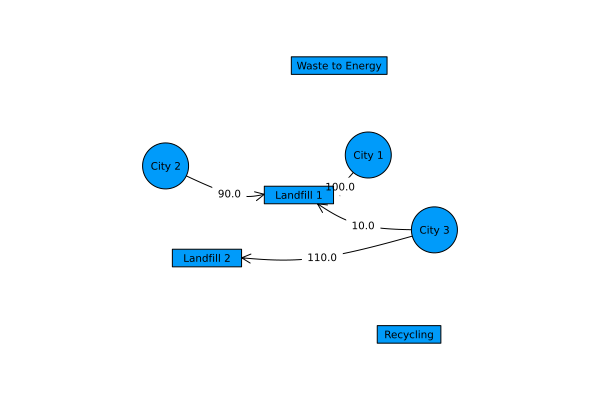

In [36]:
A= [0 0 0 1 0 0 0;
    0 0 0 1 0 0 0;
    0 0 0 1 0 0 1;
    0 0 0 0 0 0 0;
    0 0 0 0 0 0 0;
    0 0 0 0 0 0 0
    0 0 0 0 0 0 0];

location_names = ["City 1", "City 2", "City 3", "Landfill 1", "Recycling", "Waste to Energy", "Landfill 2"];
shapes=[:circle, :circle, :circle, :rect, :rect, :rect, :rect]

edge_labels=Dict((1,4)=>round(W_22[1,1]; digits=1), (2,4)=>round(W_22[2,1]; digits=1), (3,4)=>round(W_22[3,1]; digits=1), (3,7)=>round(W_22[3,4]; digits=1),)

#=
edge_labels = Dict((1, 4) => round(W_22[1,1]; digits=1), (1,5) => round(W_22[1,2]; digits=1), (1, 6) => round(W_22[1,3]; digits=1)
,(2, 4) => round(W_15[2,1]; digits=1),(2, 5) => round(W_15[2,2]; digits=1), (2, 6) => round(W_15[2,3]; digits=1)
, (3, 4) => round(W_15[3,1]; digits=1), (3, 5) => round(W_15[3,2]; digits=1), (3, 6) => round(W_15[3,3]; digits=1)
, (5,4) => round(R_15[2,1]; digits=1), (5,6) => round(R_15[2,3]; digits=1), (6,4) => round(R_15[3,1]; digits=1))
=#

xpos=[-3 -1 -3 1 2 1];
#ypos=[2 0 -2 1 0 -1];

#graphplot(A, names=location_names, markershapes=shapes, edgelabel=edge_labels, x=xpos, y=ypos);
graphplot(A, names=location_names, markershapes=shapes, edgelabel=edge_labels, markersize=0.1, x=xpos)

#### Problem 2.4 (5 points)

Would you recommend that the cities build the new landfill? Why or why
not? Your answer should be based on your analysis but can draw on other
considerations as appropriate or desired.

Based on this analysis, the city should open the second landfill, as it allows the city's waste to be handled for $26,740.00 per day, up from $26,657.37 before the carbon tax was implemented but substantially less than the cost of $32,404.16 that would be incurred under the carbon tax if the new landfill wasn't constructed. However, other factors such as the social cost of devoting land to a new landfill (especially if its placement disproportionately impacts marginalized communities), the potential lifecycle emissions benefits of utilizing MRF and/or WTE, and the possibility of implementing a residential compost service to remove food waste from the system should be considered.



## References

List any external references consulted, including classmates.

https://tex.stackexchange.com/questions/337351/multiple-lines-one-side-of-equation-with-a-curly-bracket

https://jump.dev/JuMP.jl/stable/manual/variables/

https://jump.dev/JuMP.jl/stable/manual/solutions/